In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import pooch
sc.settings.set_figure_params(dpi=50, facecolor="white")

In [2]:
#pooch manages data file => it automatically downloads and stores them in a local directory
data = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)

In [3]:
data.load_registry_from_doi()


In [5]:
# see registry associate with data
data.registry

{'s1d1_filtered_feature_bc_matrix.h5': 'md5:a99285913ea3f3d22600d3d2f8a88e34',
 's1d3_filtered_feature_bc_matrix.h5': 'md5:825f7f7578e3dc0b8955f5a97a402338'}

In [6]:
# loading a registry file that contains names, paths into data object, data now will be ready to fetch 
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5"
}

In [7]:
adatas = {}

for sample_id, filename in samples.items():
    path = data.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hienntx6/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them uni

In [12]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [19]:
adata.var

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC141272.1
AC023491.2
AC007325.1
AC007325.4


In [20]:
# annotating mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# annotating Ribosome genes: check small ribosomal subunit proteins and large ribosomal subunit proteins
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# annotating hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


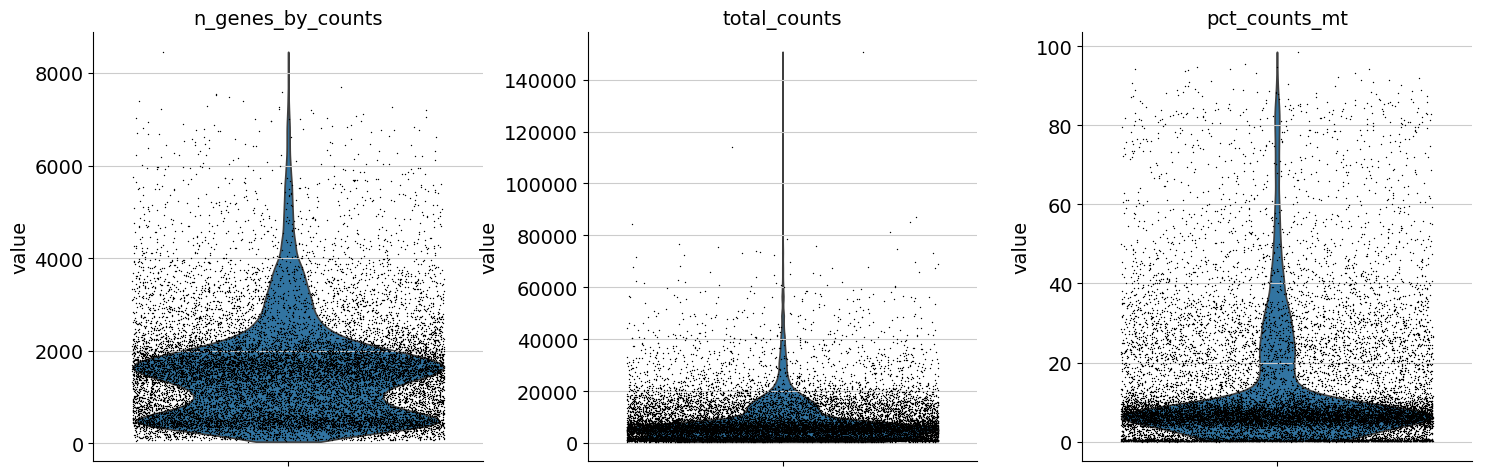

In [22]:
# plot qc information
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

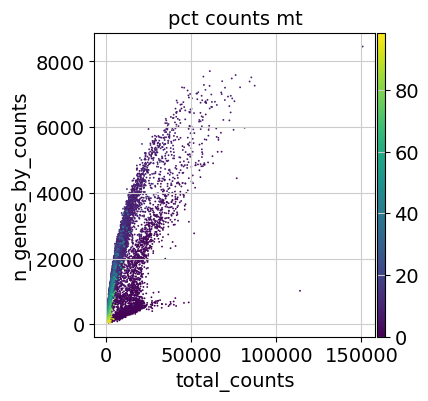

In [23]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [27]:
# filter data so that it's good quality depend on individual sample
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata = adata[adata.obs['pct_counts_mt'] < 20, :]


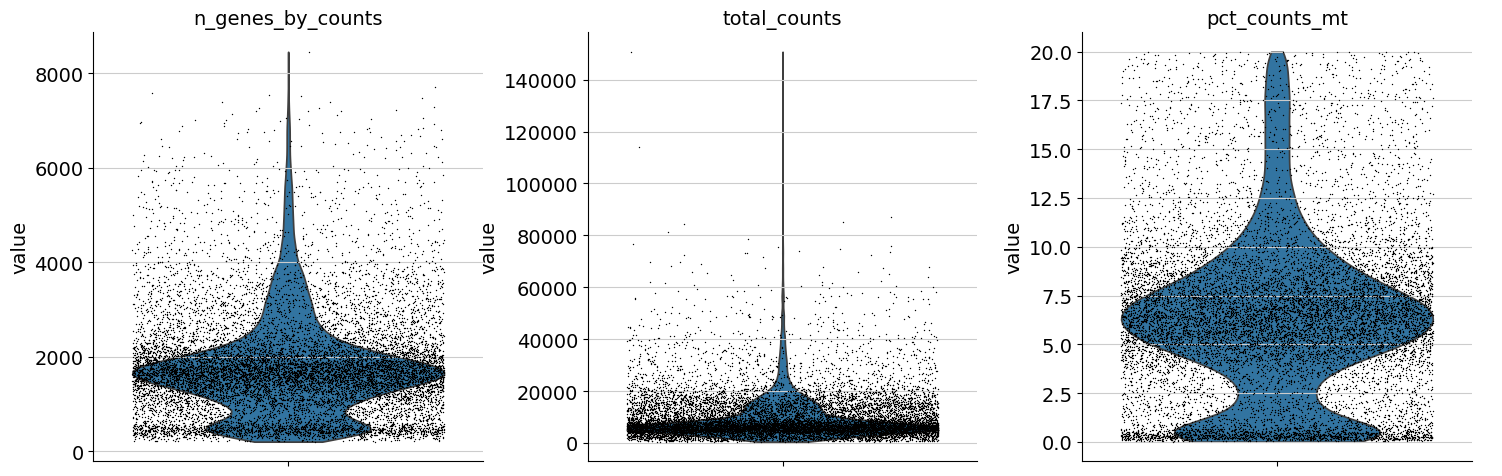

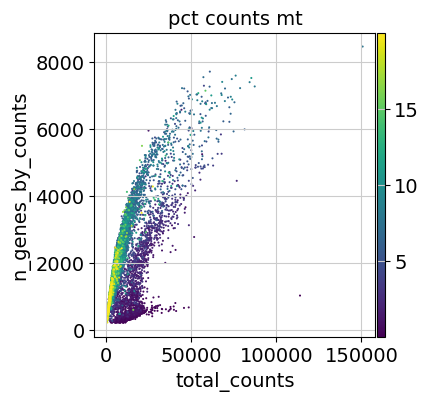

In [29]:
# plot after filtering
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [31]:
#doublet detection
sc.external.pp.scrublet(adata, batch_key="sample")


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.0%
Estimated detectable doublet fraction = 40.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.3%


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.26
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 37.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.5%


In [32]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

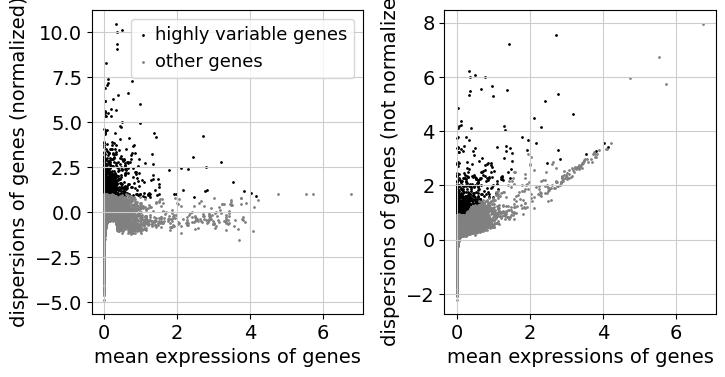

In [33]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

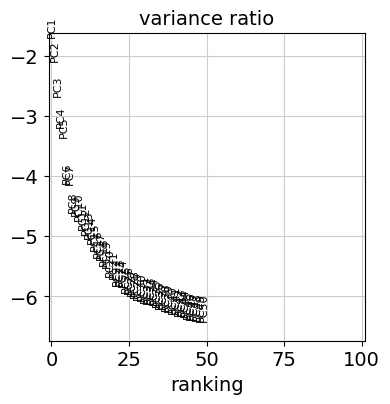

In [34]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=100, log=True)


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


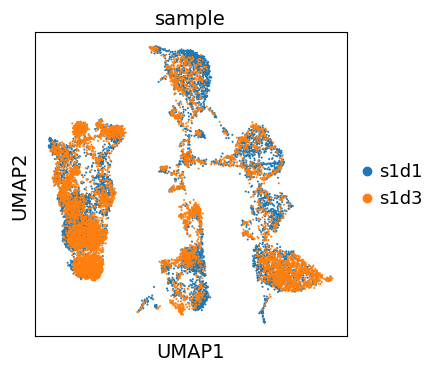

In [36]:
# using umap instead of tSNE
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


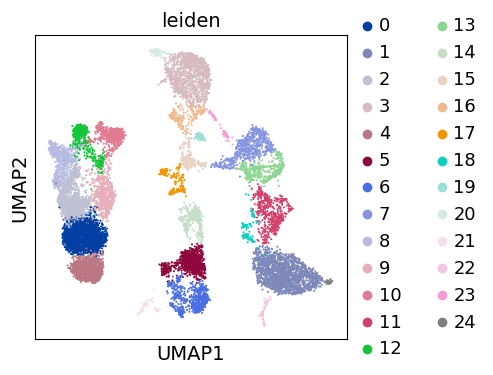

In [37]:
# The function then performs the Leiden algorithm on the data to partition the cells into clusters or communities. The resulting clusters are often represented as a categorical annotation in the adata object, allowing you to access and analyze the clustering results.
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])


In [38]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,doublet_score,predicted_doublet,leiden
AAACCCAAGGATGGCT-1,s1d1,2103,7.651596,8663.0,9.066932,42.721921,59.667552,69.744892,79.348955,460.0,...,3650.0,8.202756,42.133209,17.0,2.890372,0.196237,2103,0.054974,False,2
AAACCCAAGGCCTAGA-1,s1d1,3916,8.273081,12853.0,9.461411,35.843772,44.262040,52.376877,62.763557,1790.0,...,1719.0,7.450079,13.374310,58.0,4.077538,0.451257,3912,0.227642,False,3
AAACCCACAAGAGGCT-1,s1d1,4330,8.373554,17345.0,9.761117,27.662150,38.420294,48.901701,62.023638,780.0,...,3936.0,8.278174,22.692417,44.0,3.806663,0.253675,4327,0.037726,False,19
AAACCCACATTCTCTA-1,s1d1,1901,7.550661,4412.0,8.392310,36.876700,42.520399,50.294651,65.321850,792.0,...,210.0,5.351858,4.759746,16.0,2.833213,0.362647,1901,0.012214,False,6
AAACCCAGTCCGCAGT-1,s1d1,468,6.150603,17290.0,9.757941,95.910931,97.183343,98.438404,100.000000,93.0,...,54.0,4.007333,0.312319,15916.0,9.675143,92.053207,468,0.015678,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTCTCACAA-1,s1d3,3726,8.223359,40759.0,10.615457,68.524743,73.632817,78.895459,85.372556,1176.0,...,3252.0,8.087333,7.978606,22377.0,10.015834,54.900761,3725,0.079160,False,7
TTTGGTTTCCGTCCTA-1,s1d3,1802,7.497207,7121.0,8.870944,44.768993,61.241399,70.776576,80.775172,469.0,...,3066.0,8.028455,43.055752,22.0,3.135494,0.308945,1801,0.034807,False,0
TTTGTTGCAGACAATA-1,s1d3,3797,8.242230,13218.0,9.489410,30.753518,44.628537,53.691935,64.684521,864.0,...,3997.0,8.293550,30.239067,42.0,3.761200,0.317749,3795,0.070423,False,15
TTTGTTGCATGTTACG-1,s1d3,3089,8.035926,27280.0,10.213945,64.409824,71.671554,78.317449,85.054985,1025.0,...,3562.0,8.178358,13.057184,13145.0,9.483872,48.185482,3087,0.044809,False,7


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


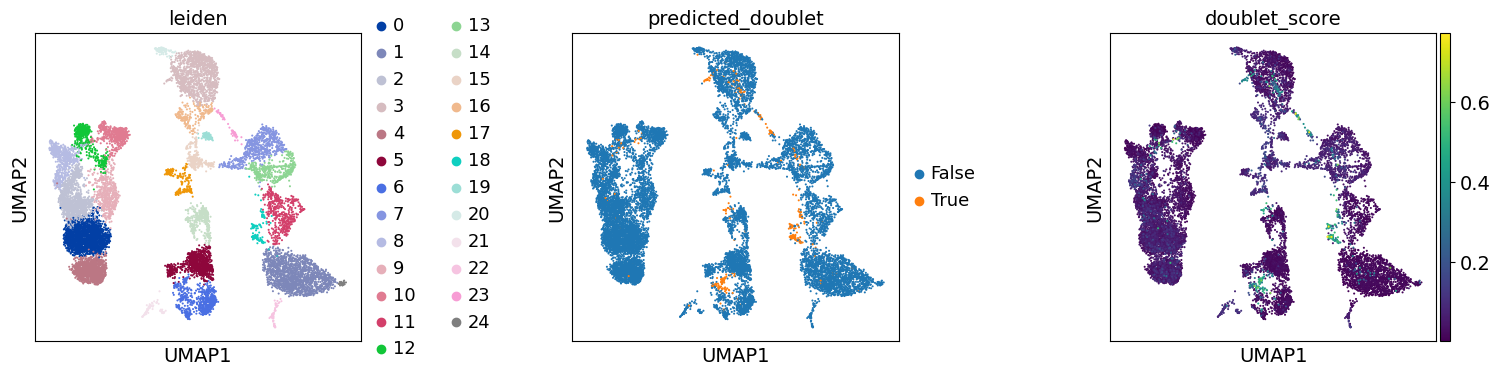

In [39]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
)


/home/hienntx6/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


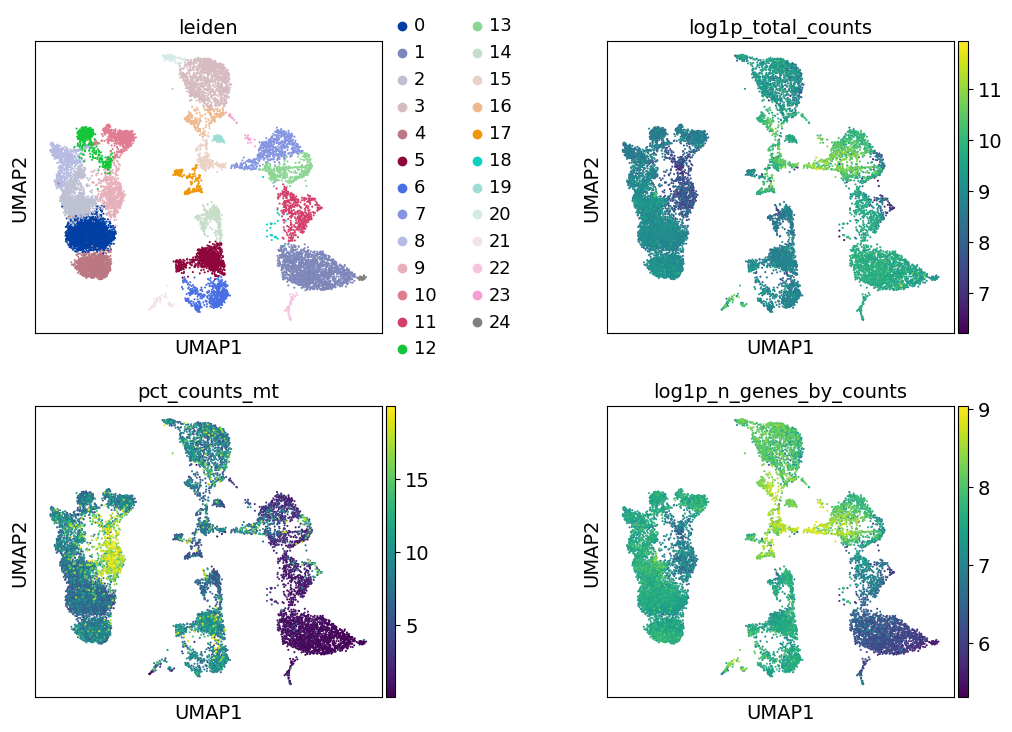

In [40]:
adata = adata[~adata.obs["predicted_doublet"].to_numpy()].copy()
sc.pl.umap(
    adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2
)

**Cell type annotation**

In [41]:
import celltypist as ct
import decoupler as dc

In [42]:
sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

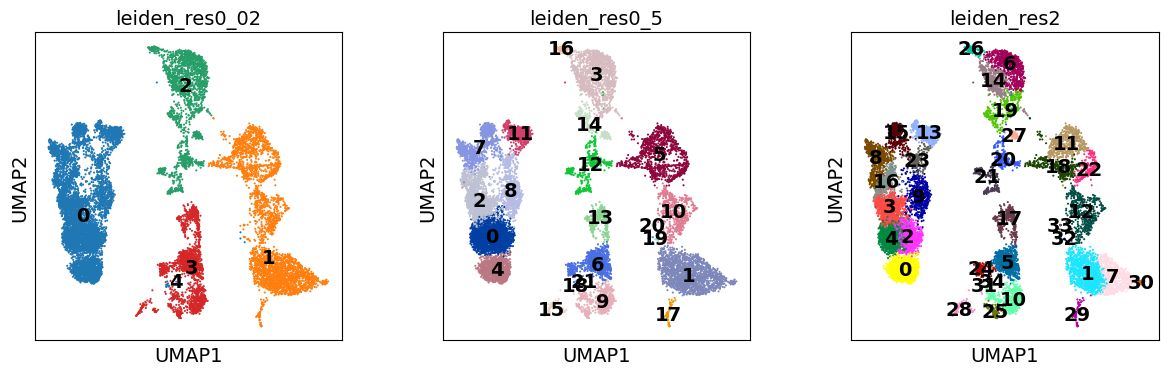

In [43]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

**Apply to marker genes**

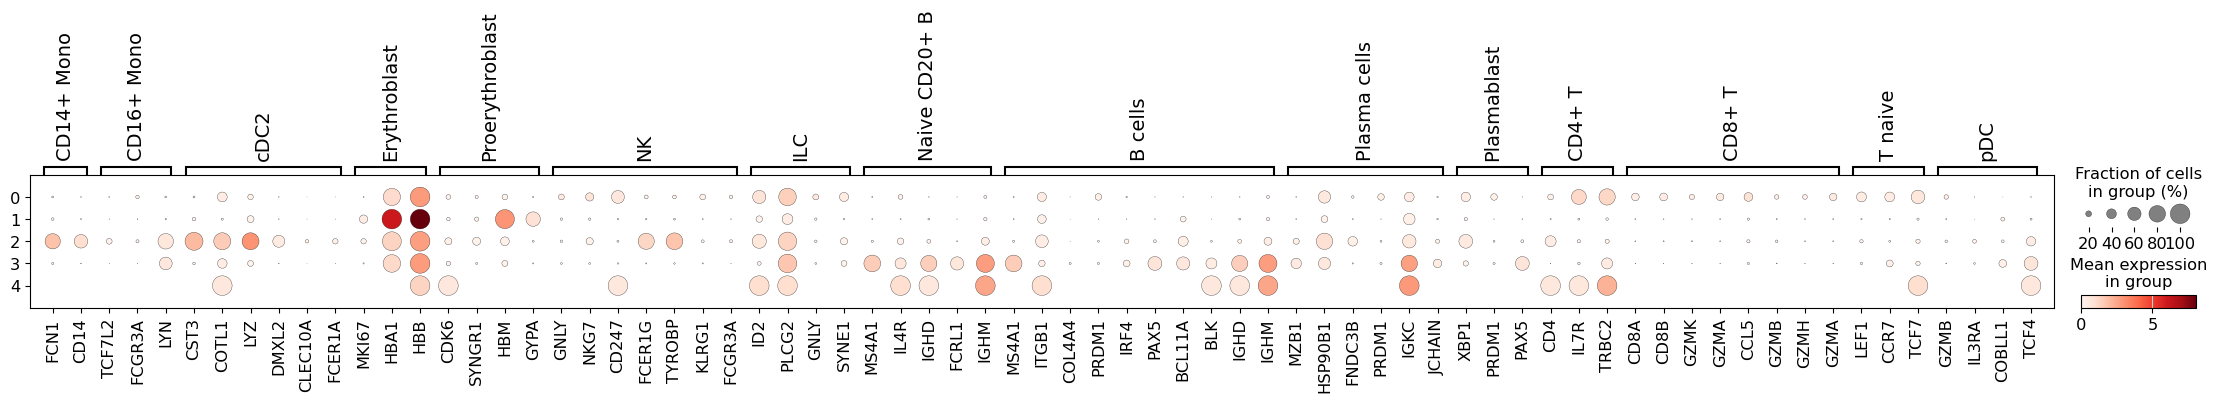

In [44]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],  # Note IGHD and IGHM are negative markers
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res0_02")

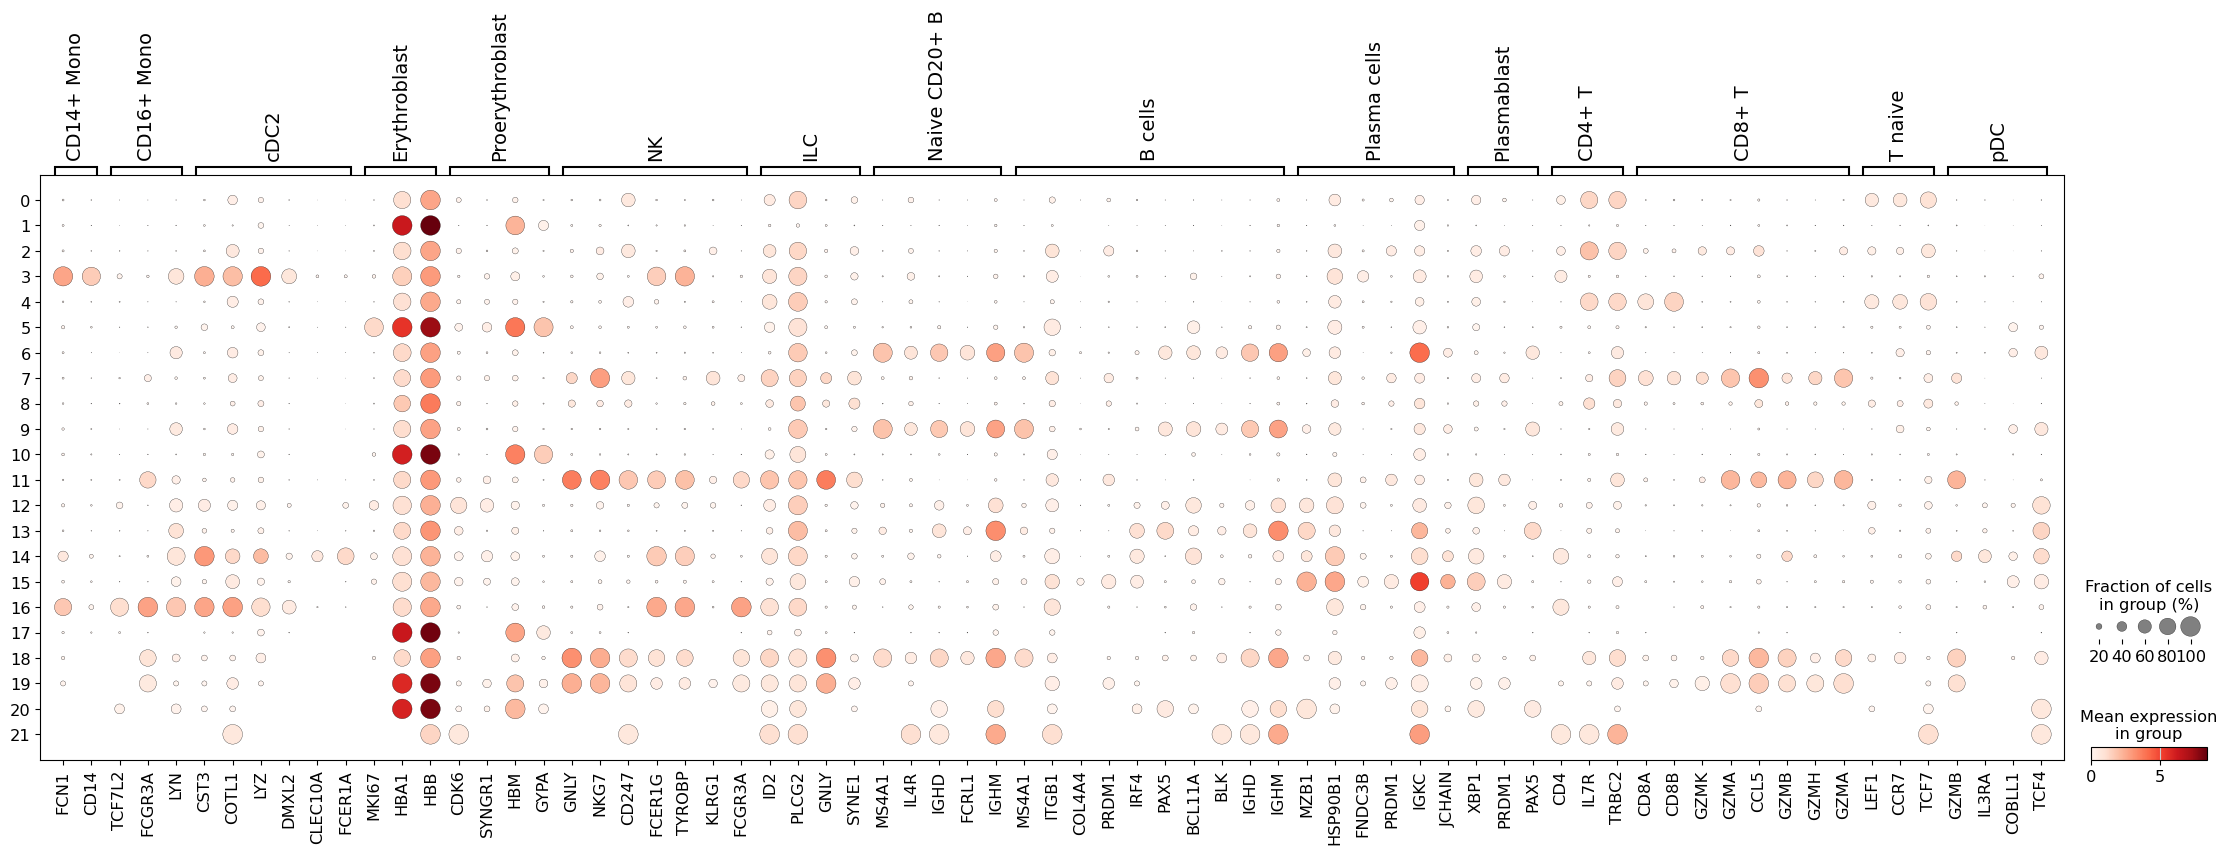

In [45]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res0_5")

... storing 'manual_anno' as categorical


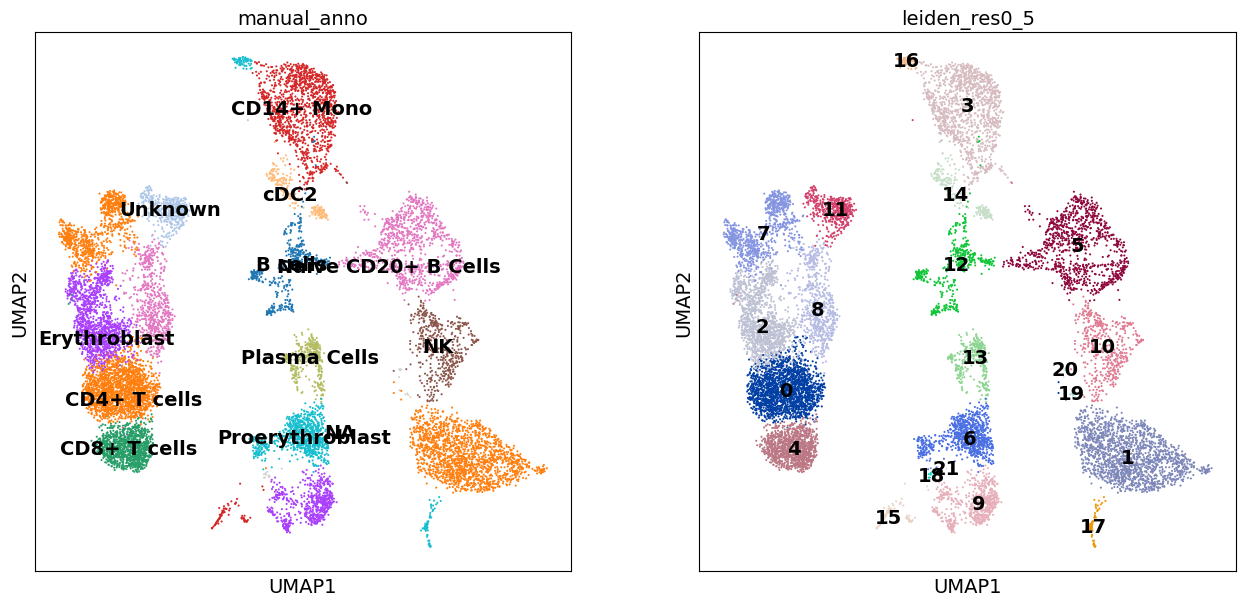

In [46]:
new_cluster_names = {
    "0": "CD4+ T cells",
    "1": "CD4+ T cells",
    "2": "Erythroblast",
    "3": "CD14+ Mono",
    "4": "CD8+ T cells",
    "5": "Naive CD20+ B Cells",
    "6": "Proerythroblast",
    "7": "CD4+ T cells",  # though questinable
    "8": "Naive CD20+ B Cells",
    "9": "Erythroblast",
    "10": "NK",
    "11": "Unknown",
    "12": "B cells",
    "13": "Plasma Cells",
    "14": "cDC2",
    "15": "CD14+ Mono",
    "16": "Proerythroblast",
    "17": "Proerythroblast",
}
adata.obs["manual_anno"] = adata.obs["leiden_res0_5"].map(new_cluster_names)
with plt.rc_context({"figure.figsize": (7, 7)}):
    sc.pl.umap(
        adata,
        color=["manual_anno", "leiden_res0_5"],
        legend_loc="on data",
    )

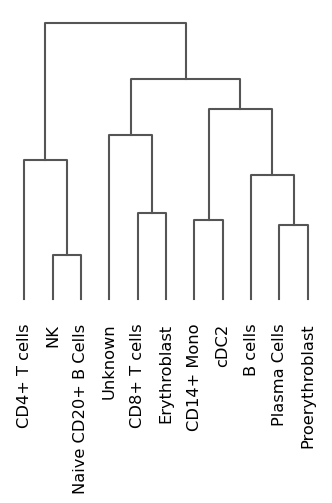

<Axes: >

In [47]:
sc.pl.dendrogram(adata, groupby="manual_anno")